<a href="https://colab.research.google.com/github/akabago/ZeroCostDL4Mic-VirtualMultiplexing/blob/main/ZC_VirtualMultiplexing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # **ZeroCostDL4mic-Virtual-Multiplexing**
 ---
 
Virtual Multiplexing is a deep learning method based on pix2pix which allows image to image translation. It performs signal unmixing in images obtained from inmunofluorescence with overlaping signal between 2 markers. 

With this notebook you will be able to: 

**1.**   Read a .czi and generate paired data for training, continue the training  or test a virtual multiplexing model with your own data. 

**2.**  Read a .czi and extracts mixed signal images to use a virtual multiplexing model previously trained for signal unmixing. 

---

This notebook is based on the following papers: 

1. Isola, P., Zhu, J., Zhou, T., & Efros, A. A. (2016). Image-to-Image Translation with Conditional Adversarial Networks. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1611.07004 

2. Von Chamier, L., Laine, R. F., Jukkala, J., Spahn, C., Krentzel, D., Nehme, E., Lerche, M., Hernández-Pérez, S., Mattila, P. K., Karinou, E., Holden, S., Solak, A. C., Krull, A., Buchholz, T., Jones, M., Royer, L., Leterrier, C., Shechtman, Y., Jug, F., . . . Henriques, R. (2021). Democratising deep learning for microscopy with ZeroCostDL4Mic. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-22518-0

The source code for pix2pix implementation can be found here: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix


## **0. How to use this notebook?**
---
To use this notebook there is a video tutorial step by step where is the complete workflow. You can access it here.

### **General user workflow**
--- 

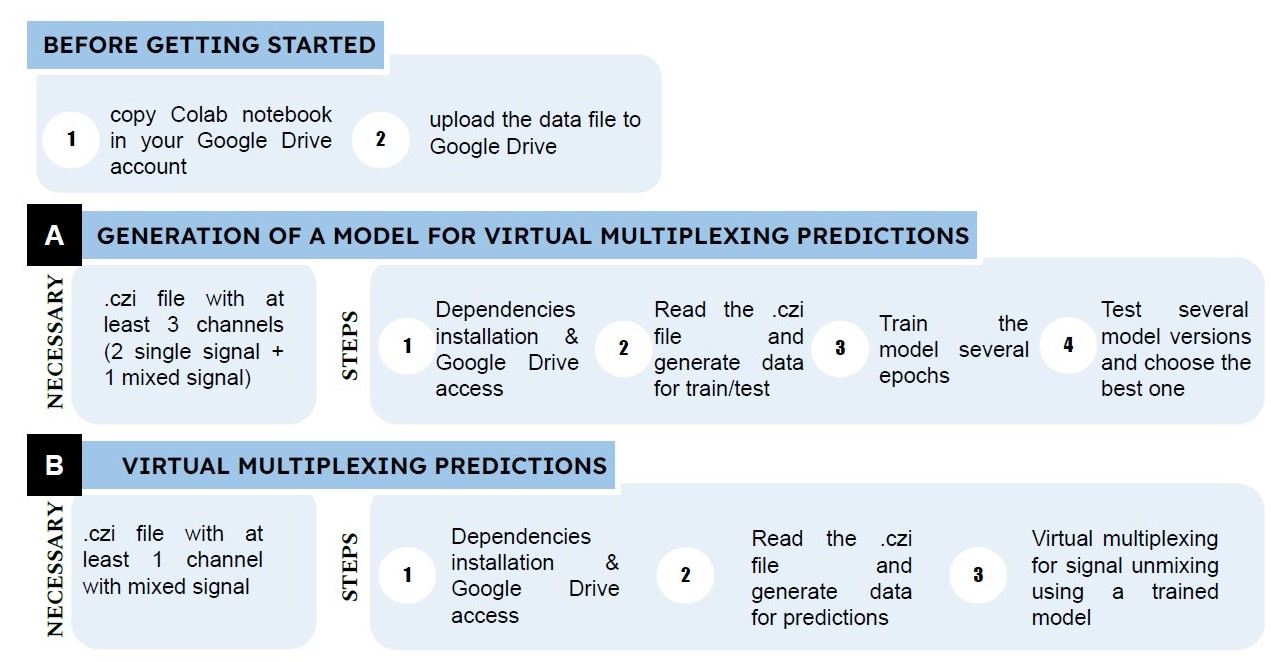


### **What steps do I need to follow?**
---

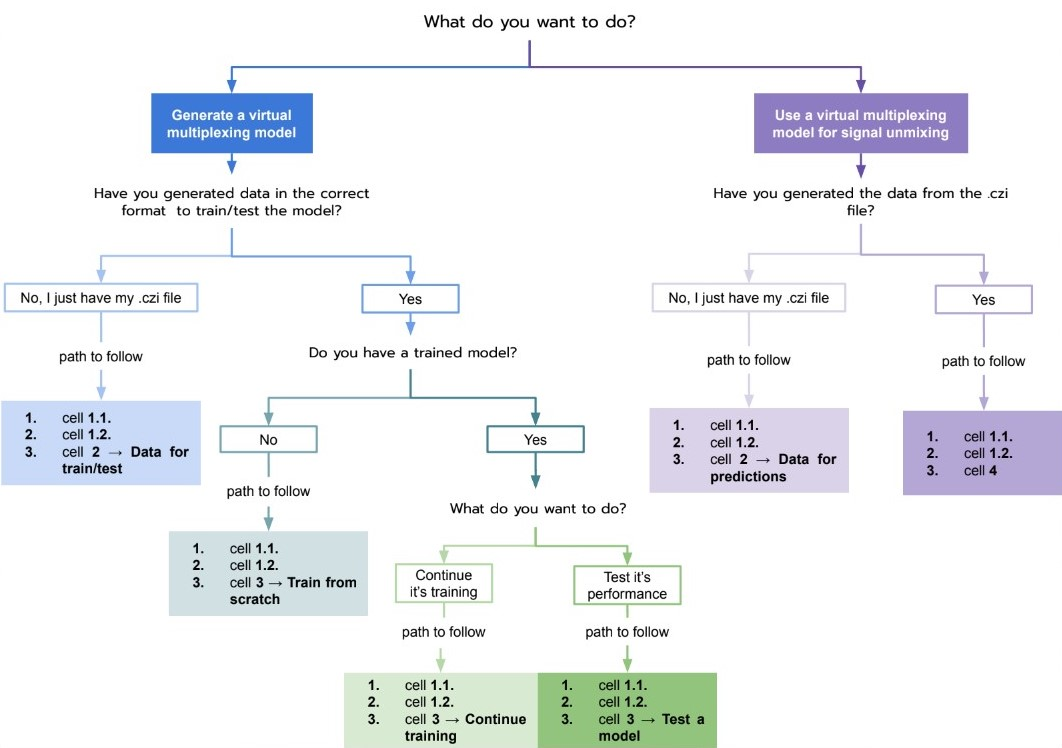

## **1. Getting started**
---
In order to use the tools provided in this notebook it is necessary to install dependencies as well as mount your Google Drive account.

### **1.1. Dependencies installation**
---

In [ ]:
#@markdown ###Play the cell to install the dependencies 
'''
Modules needed for the preprocessing of STAPL3D that is going to be imported
For the mpi4py it is needed to intall Microsoft MPI if this is done in a Jupyter Notebook and you don´t have it. 
In Google Colab it isn´t needed to install MPI.
'''
!pip install pyqt5==5.12.3 pyqtwebengine==5.12.1
!pip install napari
!pip install mpi4py PyPDF2 czifile readlif

'''
Installation of STAPL3D. 
Be careful if you don't have git installed in the enviroment it will be needed to install it, again, in Colab it is not needed
'''
!pip install git+https://github.com/RiosGroup/STAPL3D.git

'''
Module imports
'''
import numpy as np
from stapl3d.preprocessing import shading
import matplotlib.pyplot as plt
import argparse
import matplotlib
import random
import os
import cv2 
from PIL import Image, ImageEnhance
from skimage import io
from skimage import color
from skimage import exposure
import matplotlib.image as mpimg

'''
ipywidgets is a package that allows to insert widgets in the jupyter notebook
'''
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import ButtonStyle, Layout
from IPython.core.display import clear_output

'''
Below I am clonning the repository where can it can be found the DataGenerator 
code 
'''

!git clone https://github.com/akabago/ZeroCostDL4Mic-VirtualMultiplexing.git

'''
pix2pix and it's dependencies installation
'''
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
!pip install -r pytorch-CycleGAN-and-pix2pix/requirements.txt

'''
Visdom server process - it is needed for train.py
'''
!pip install visdom

'''
For making predictions
'''
!pip install tensorboardX

### **1.2. Google Drive Access**
---

In [2]:
#@markdown  ###Play the cell to connect your Google Drive account to Colab Notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Read a .czi file and generate data**
---

Here you can read .czi file for two different purposes depending on which window do you select: 

*   **Data for train/test**. It will preprocess the data and generate paired images that are suitable for train and test a virtual multiplexing model. 
*   **Data for predictions**. It will preprocess the data with mixed signal and generate images that are suitable to be used for a virtual multiplexing model which will unmix the signals.

In [ ]:
#@markdown ### Play this cell and  follow the instructions below.

#@markdown **1. Select the page that corresponds with the final purpose of the data:** train/test a model or making predictions using a pretrained model.

#@markdown **2. Complete the fields and choose the parameter configuration.**

#@markdown **3. Click on the button and generate the data.**

# STYLE PARAMETERS COMMON FOR SOME WIDGETS 

style = {'description_width': 'initial'}  # with this when the description is too long it allows to display it all


## ------------------------ DATA GENERATOR FOR TRAIN/TEST A MODEL----------------------------

# OUTPUT HANDLING

output = widgets.Output()
outputa = widgets.Output()
outputb = widgets.Output()

# ESSENTIAL PARAMETER CONFIGURATION BUTTONS - path configuration

'''
path configuration
'''

label4 = widgets.Label("Please fill in the path configuration.",
                       style = style)
'''
Help button
'''

help_path = widgets.Button(description = 'Help')
help_path.style.button_color = 'lemonchiffon'


help_path_msg = '''
  In this page you must complete the following fields: 

  -	Directory of the file with .czi extension. Write the complete path where the .czi file is placed 
    in your Google Drive followed by the name of the file.czi. 
    An example is: /content/gdrive/MyDrive/MyProject/Data.czi

  -	Directory of the output. Write the complete path to the folder where you want to store the result 
    of reading the .czi file and image generation. 
    An example is: /content/gdrive/MyDrive/MyProject/Images (where Images is a folder that will contain
    a folder with the result of the program). 

  -	Sample name. Write the name or identification code of the sample from where the .czi file comes from. 
'''

def help_pathmsg(msg): 
  with output: 
    print(help_path_msg)
    clear_output(wait=True)

help_path.on_click(help_pathmsg)

'''
Path of the 3D dataset
'''

czi_path = widgets.Text(
    description ='Directory of the file with .czi extension:', 
    placeholder = 'Type here the path for file followed by the filename.czi', 
    style = style, 
    layout=Layout(width='800px')
) 

'''
Output pathway
'''

output_path = widgets.Text(
    description = 'Directory of the output:', 
    placeholder = 'Type here the path where you want the generated data to be saved', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Biosample
'''

biosample_name = widgets.Text(
    description='Sample name:', 
    placeholder='Type here the name of the sample from which the file comes from', 
    style = style, 
    layout=Layout(width='800px')
)

# ESSENTIAL PARAMETER CONFIGURATION BUTTONS - parameter configuration

'''
Parameter configuration
'''

label5 = widgets.Label("Please configure the following parameters for data generation.", 
                       style = style)
'''
Help Button
'''

help_params = widgets.Button(description = 'Help')
help_params.style.button_color = 'lemonchiffon'

help_params_msg = '''
  For generating the data from the .czi file you will have to configure the parameters below: 

    -	Number of training images. Write the desired number of training images that you want to generate 
      from the .czi file for training the model. Consider that 20% of that number will be the number 
      of images that will be generated for validating and test the model.

    -	Datatype. This parameter is for selecting how do you want to generate mixed signal data. You must 
      choose between three options: 
        o	Open detector. Mixed signal obtained from open detector approach as source for extract patches. 
        o	Synthetic. Mixed signal data is obtained from blending the patches extracted from both marker 
          signal channels. 
        o	Weighted. Mixed signal is obtained from an alpha value contribution of the mixed signal channel
          1, and 1 – alpha contribution of the mixed signal channel 2. This is for introducing variation 
          in the source image in terms of signal contribution. If you choose this option, you must configure 
          the alpha value below. 

    -	Alpha value. Parameter only available if weighted datatype selected before. This is the contribution 
      of marker signal channel 1 for generating mixed signal data. The contribution of marker signal 2 will 
      be 1 – alpha. 

    -	Bottom and Top Layer. Specify the z-axis range from which patches are extracted.

    -	Marker signal channel 1. Write the number of the channel in your .czi file where you have the data of 
      the signal of one marker. 

    -	Marker signal channel 2. Write the number of the channel in your .czi file where you have the data of 
      the signal of one marker. 

    -	Mixed signal channel. Write the number of the channel in your .czi file where you have the data of 
      mixed signal. 
'''

def help_paramsmsg(msg): 
  with outputa: 
    print(help_params_msg)
    clear_output(wait=True)

help_params.on_click(help_paramsmsg)

'''
Dataset Size
'''

dataset_size = widgets.IntText(
    value = 1000, 
    description="Number of training images:",  
    disabled=False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
DataMode
'''

data_mode = widgets.Dropdown(
    description='Data Type:',
    options=[('Open detector', 'open_detector'), ('Synthetic','synthetic'), ('Weighted', 'weighted')], 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Alpha: it is only needed to be set if weighted data mode option is choosen
'''

alpha = widgets.FloatSlider(
    min = 0.2, 
    max = 0.8, 
    step = 0.05,
    description='Alpha value:',
    disabled = True, 
    style = style, 
    layout = widgets.Layout(width='270px')
)
  # enabling alpha button just when weighted is selected

def data_mode_weighted(change): 
  if change['new'] == 'weighted': 
    alpha.disabled = False
    alpha.value = 0.5
  else: 
    alpha.disabled = True
    alpha.value = 0

data_mode.observe(data_mode_weighted, 'value')


'''
Bottom and Top Layers
'''

bottom_layer = widgets.IntText(
    value = 67, 
    description='Bottom Layer:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

top_layer = widgets.IntText(
    value = 69, 
    description='Top Layer:', 
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Selection of channels buttons
'''

label4a = widgets.Label("Indicate which channel (position) from your .czi file you want to use to generate data.",
                       style = style)
ch1 = widgets.BoundedIntText(
    value = 1, 
    min = 1,
    description='Marker signal channel 1:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

ch2 = widgets.BoundedIntText(
    value = 2, 
    min = 1,
    description='Marker signal channel 2:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

ch3 = widgets.BoundedIntText(
    value = 3, 
    min = 1, 
    description='Mixed signal channel:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

# ADVANCED PARAMETER CONFIGURATION BUTTONS

'''
Advanced options: normalization, patch size and brightness augmentation

Here when the button that appears is pressed it enables to change the default values for 
the type of normalization as well as the number for the patch_size. If the button isn´t 
pressed the user won´t be able to modify this values. 

For doing this in the code, first we define the widgets for the normalization, patch_size and brightness 
augmentation button and value widget, followed by the toggle button that allows to change both of them. 
This is defined in the toggle advanced option that stablishes the disabled option from the widget depending
on the state of the toggle button for the advanced parameters.
.observe allows us to change the output of the normalization and patch size options that are defined in 
the toggle_advanced function. 

'''

'''
Advanced parameters 
'''
label6 = widgets.Label("Advanced parameter settings.",
                       style = style)

'''
Help button
'''

help_advanced = widgets.Button(description = 'Help')
help_advanced.style.button_color = 'lemonchiffon'

help_adv_msg = '''
  The advanced settings are set to default values, for modifying them you must click on the blue 
  button (this will allow to change them). 

    WARNING! This is just recommended for experienced users! If you regret changing these parameters, 
    just click again the button for enabling advanced parameters, and they will be set again to the
    default values. 

  The parameters you can modify are the following: 

    -	Image size. Be careful because it can't exceed the size of the tile in the CZI file. 

    -	Normalization. For the data normalization you can choose between 2 different approaches: 

        o	Open detector percentiles. Normalization of each channel using its corresponding calculated 
          percentile value.

        o	All channels’ percentiles. Normalization of the three channels using the calculated percentile 
          value of the third channel.

      -	Brightness augmentation. This will introduce intensity variation. For implementing it, you must 
        click on the blue button, and then you will be able to slide the bar to choose the brightness 
        augmentation %. 
'''

def help_advmsg(msg): 
  with outputb: 
    print(help_adv_msg)
    clear_output(wait=True)

help_advanced.on_click(help_advmsg)

'''
Patch size
'''

patch_size = widgets.IntText(
    value = 512, 
    description = 'Image size:', 
    disabled  = True, 
    style = style, 
    layout=Layout(width='250px')
    )

'''
Normalization
'''

normalization = widgets.Dropdown(
    description = 'Normalization:', 
    options=[('Open detector percentile', 'od'), ('All channels percentiles', 'ac')], 
    value = 'ac',
    disabled=True, 
    style = style, 
    layout=Layout(width='250px')
    )

'''
% brightness value
'''

brightness_value = widgets.IntSlider(
    min = 0,
    max= 100, 
    description = '% brightness variation:', 
    disabled = True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style, 
    layout=Layout(width = '845px')
    )


'''
Enable brightness augmentation button and configuration 
'''

brightness = widgets.ToggleButton(value = False, 
                                  description = 'Click on me to use brightness augmentation', 
                                  button_style='info', 
                                  disabled=True,
                                  style = style, 
                                  layout=Layout(width='815px')
                                  )

def brightness_options(change): 
  if change['new']: 
    brightness_value.disabled = False
    brightness_value.value = 50
  else: 
    brightness_value.disabled = True
    brightness_value.value = 0

brightness.observe(brightness_options, 'value')

'''
Enable advanced parameters button and configuration
'''

advanced_params = widgets.ToggleButton(value = False, 
                                       description = 'Click on me to enable advanced settings configuration', 
                                       button_style='info', 
                                       style = style, 
                                       layout=Layout(width='815px')
                                       )

def toggle_advanced(change): 
  if change['new']: 
    normalization.disabled = False
    patch_size.disabled = False
    brightness.disabled = False
  else: 
    normalization.disabled = True
    normalization.value = 'ac'
    #normalization.options=[('All channels percentiles', 'ac')]
    patch_size.disabled = True
    patch_size.value = 512
    brightness.disabled = True
    brightness.value = False

advanced_params.observe(toggle_advanced, 'value')

# STANDARD PARAMETERS

'''
Set default values. 
This are the percentile and the number of channels values that aren´t going to be customed by the user. 
The number of channels it is because by the moment the DataGenerator is only setted for a 3 channels options. 
The percentile number is going to remain in 99 because it is the best option
'''

channels_trte = 3
percentile_val = 99

# RUN DATAGENERATOR.PY BUTTON

'''
Running DataGenerator.py with a button
For this first is set the button widget, after this data_gen function contains the bash command lines for 
first running the DataGeneratory.py imported from GitHub and after this the result is moved to the desidered 
output for the user since DataGenerator.py saves the result in the folder where is set this script. 
.on_click function allows to run the data_gen function when the button is clicked. 
'''

output1 = widgets.Output()

data_gen_button = widgets.Button(description = 'Click on me to generate the data for train/test a model', 
                                 layout=Layout(width='845px')
                                 )
data_gen_button.style.button_color = 'yellowgreen'

def data_gen(b): 
  with output1: 
    print('Data is being generated, this will take some time...')
    if data_mode.value == 'weighted': 
      !python /content/ZeroCostDL4Mic-VirtualMultiplexing/Tools/DataGenerator.py --Role train_test --Filepath $czi_path.value --Percentile $percentile_val --PatchSize $patch_size.value --Channels $channels_trte --Channel1 {int(ch1.value-1)} --Channel2 {int(ch2.value-1)} --Channel3 {int(ch3.value-1)} --BottomLayer $bottom_layer.value --TopLayer $top_layer.value --Biosample $biosample_name.value --DatasetSize $dataset_size.value --DataMode $data_mode.value --Alpha $alpha.value --Normalization $normalization.value --Brightness $brightness_value.value
      !mv $biosample_name.value* $output_path.value
    else: 
      !python /content/ZeroCostDL4Mic-VirtualMultiplexing/Tools/DataGenerator.py --Role train_test --Filepath $czi_path.value --Percentile $percentile_val --PatchSize $patch_size.value --Channels $channels_trte --Channel1 {int(ch1.value-1)} --Channel2 {int(ch2.value-1)} --Channel3 {int(ch3.value-1)} --BottomLayer $bottom_layer.value --TopLayer $top_layer.value --Biosample $biosample_name.value --DatasetSize $dataset_size.value --DataMode $data_mode.value --Normalization $normalization.value --Brightness $brightness_value.value
    
      !mv $biosample_name.value* $output_path.value
    print('Data has been generated!')
    clear_output(wait = True)

data_gen_button.on_click(data_gen)



## ------------------------ DATA GENERATOR FOR PREDICTIONS ----------------------------

# OUTPUT HANDLING

outputc = widgets.Output()
outputd = widgets.Output()
outpute = widgets.Output()

# ESSENTIAL PARAMETER CONFIGURATION BUTTONS - path configuration

'''
Label 4 and help_path_msg are the same as in the ones used in the page of 'Data for
train/test. 
'''

help_path1 = widgets.Button(description = 'Help')
help_path1.style.button_color = 'lemonchiffon'

def help_pathmsg1(msg): 
  with outputc: 
    print(help_path_msg)
    clear_output(wait=True)

help_path1.on_click(help_pathmsg1)

'''
Path of the 3D dataset
'''

czi_path1 = widgets.Text(
    description ='Directory of the file with .czi extension:', 
    placeholder = 'Type here the path for file followed by the filename.czi', 
    style = style, 
    layout=Layout(width='800px')
) 

'''
Output pathway
'''

output_path1 = widgets.Text(
    description = 'Directory of the output:', 
    placeholder = 'Type here the path where you want the generated data to be saved', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Biosample
'''

biosample_name1 = widgets.Text(
    description='Sample name:', 
    placeholder='Type here the name of the sample from which the file comes from', 
    style = style, 
    layout=Layout(width='800px')
)

# ESSENTIAL PARAMETER CONFIGURATION BUTTONS - parameter configuration

'''
Parameter configuration. Label 5 is the same as in the previous page so it's already defined. 
Here the help message changes a bit, so it 's needed to define a new message. 
'''

'''
Help Button
'''

help_params1 = widgets.Button(description = 'Help')
help_params1.style.button_color = 'lemonchiffon'

help_params_msg1 = '''
  For generating the data from the .czi file you will have to configure the parameters below: 

    -	Bottom and Top Layer. Specify the z-axis range from which patches are extracted.

    -	Mixed signal channel. Write the number of the channel in your .czi file where you have 
      the data of mixed signal. 
'''

def help_paramsmsg1(msg): 
  with outputd: 
    print(help_params_msg1)
    clear_output(wait=True)

help_params1.on_click(help_paramsmsg1)

'''
Bottom and Top Layers
'''

bottom_layer1 = widgets.IntText(
    value = 67, 
    description='Bottom Layer:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

top_layer1 = widgets.IntText(
    value = 69, 
    description='Top Layer:', 
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Selection of channels buttons
'''

ch_mix = widgets.BoundedIntText(
    value = 1, 
    min = 1, 
    description='Mixed signal channel:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

# ADVANCED PARAMETER CONFIGURATION BUTTONS

'''
Advanced options: normalization, patch size and brightness augmentation

Here when the button that appears is pressed it enables to change the default values for 
the number for the patch_size, normalization isn't defined since it can only done in this case with the selected channel. 
If the button isn´t pressed the user won´t be able to modify this values. 

For doing this in the code, first we define the widgets for the normalization, patch_size and brightness 
augmentation button and value widget, followed by the toggle button that allows to change both of them. 
This is defined in the toggle advanced option that stablishes the disabled option from the widget depending
on the state of the toggle button for the advanced parameters.
.observe allows us to change the output of the normalization and patch size options that are defined in 
the toggle_advanced function. 

'''

'''
Advanced parameters . Here we will use label6 previously defined
'''

'''
Help button.
'''

help_advanced1 = widgets.Button(description = 'Help')
help_advanced1.style.button_color = 'lemonchiffon'

help_adv_msg1 = '''
  The advanced settings are set to default values, for modifying them you must click on the 
  blue button (this will allow to change them). 

    WARNING! This is just recommended for experienced users! If you regret changing these 
    parameters, just click again the button for enabling advanced parameters, and they will 
    be set again to the default values. 

  The parameters you can modify are the following: 

    -	Image size. Be careful because it can't exceed the size of the tile in the CZI file. 

    -	Brightness augmentation. This will introduce intensity variation. For implementing it, 
      you must click on the blue button, and then you will be able to slide the bar to choose 
      the brightness augmentation %. 
'''

def help_advmsg1(msg): 
  with outpute: 
    print(help_adv_msg1)
    clear_output(wait=True)

help_advanced1.on_click(help_advmsg1)

'''
Patch size
'''

patch_size1 = widgets.IntText(
    value = 1024, 
    description = 'Image size:', 
    disabled  = True, 
    style = style, 
    layout=Layout(width='250px')
    )

'''
Normalization
'''

normalization1 = 'ac'

'''
% brightness value
'''

brightness_value1 = widgets.IntSlider(
    min = 0,
    max= 100, 
    description = '% brightness variation:', 
    disabled = True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style, 
    layout=Layout(width = '450px')
    )


'''
Enable brightness augmentation button and configuration 
'''

brightness1 = widgets.ToggleButton(value = False, 
                                  description = 'Click on me to use brightness augmentation', 
                                  button_style='info', 
                                  disabled=True,
                                  style = style, 
                                  layout=Layout(width='350px')
                                  )

def brightness_options1(change): 
  if change['new']: 
    brightness_value1.disabled = False
    brightness_value1.value = 50
  else: 
    brightness_value1.disabled = True
    brightness_value1.value = 0

brightness1.observe(brightness_options1, 'value')

'''
Enable advanced parameters button and configuration
'''

advanced_params1 = widgets.ToggleButton(value = False, 
                                       description = 'Click on me to enable advanced settings configuration', 
                                       button_style='info', 
                                       style = style, 
                                       layout=Layout(width='350px')
                                       )

def toggle_advanced1(change): 
  if change['new']: 
    patch_size1.disabled = False
    brightness1.disabled = False
  else: 
    patch_size1.disabled = True
    patch_size1.value = 512
    brightness1.disabled = True
    brightness1.value = False

advanced_params1.observe(toggle_advanced1, 'value')

# RUN DATAGENERATOR.PY BUTTON

'''
Running DataGenerator.py with a button
For this first is set the button widget, after this data_gen function contains the bash command lines for 
first running the DataGeneratory.py imported from GitHub and after this the result is moved to the desidered 
output for the user since DataGenerator.py saves the result in the folder where is set this script. 
.on_click function allows to run the data_gen function when the button is clicked. 
'''

output1 = widgets.Output()

data_gen_button1 = widgets.Button(description = 'Click on me to generate the data for predictions', 
                                 layout=Layout(width='845px')
                                 )
data_gen_button1.style.button_color = 'yellowgreen'

def data_gen1(b): 
  with output1: 
    print('Data is being generated, this will take some time ...')
    !python /content/ZeroCostDL4Mic-VirtualMultiplexing/Tools/DataGenerator.py --Role predict --Filepath $czi_path1.value --Percentile $percentile_val --PatchSize $patch_size1.value --Channels 1 --Channel3 {int(ch_mix.value-1)} --BottomLayer $bottom_layer1.value --TopLayer $top_layer1.value --Biosample $biosample_name1.value --DataMode open_detector --Normalization ac --Brightness $brightness_value1.value
    !mv $biosample_name1.value* $output_path1.value
    print('Data has been generated!')
    clear_output(wait = True)

data_gen_button1.on_click(data_gen1)



## ------------------------ BUTTONS DISPLAY'S ----------------------------

### DISPLAY OF DATA GENERATION FOR TRAIN AND TEST 

#### ESSENTIAL PARAMETERS TAB: parameters and path

paths_des_help = widgets.HBox([label4, help_path], 
                              layout=Layout(grid_gap = '20px 385px'))
paths = widgets.VBox(children=[paths_des_help, output, czi_path, output_path, biosample_name], 
                     layout=Layout(margin='15px 10px', 
                                   grid_gap = '20px 175px'))

param_layout0 = widgets.HBox([label5, help_params], 
                             layout=Layout(grid_gap = '20px 315px'))
param_layout1 = widgets.HBox([dataset_size, bottom_layer], 
                             layout=Layout(grid_gap = '20px 295px'))
param_layout2 = widgets.HBox([data_mode, top_layer],
                             layout=Layout(grid_gap = '20px 295px'))
param_layout3 = widgets.HBox([ch1, ch2, ch3],
                             layout=Layout(grid_gap = '20px 20px'))
parameters = widgets.VBox([param_layout0, outputa, param_layout1, param_layout2, alpha, label4a, param_layout3], 
                     layout=Layout(margin='15px 10px', 
                                   grid_gap = '20px 175px'))



essential = widgets.Tab(children=[paths, parameters])
essential.set_title(0, 'Path')
essential.set_title(1, 'Parameters')

#### ESSENTIAL & ADVANCED PARAMETERS TAB

##### Advanced page
adv_layout0 = widgets.HBox([label6, help_advanced], 
                           layout=Layout(grid_gap = '20px 490px'))
adv_layout1 = widgets.HBox([patch_size, normalization], 
                           layout=Layout(grid_gap = '20px 315px'))
advanced = widgets.VBox([adv_layout0, outputb, advanced_params, adv_layout1, brightness, brightness_value], 
                        layout=Layout(margin='15px 10px', 
                                      grid_gap = '20px 175px'))
##### Both pages

essen_adv = widgets.Tab(children = [essential, advanced])
essen_adv.layout.width = '1000px'
essen_adv.set_title(0, 'Essential Settings')
essen_adv.set_title(1, 'Advanced Settings')


#### DATA GENERATION FOR TRAIN AND TEST PAGE - page display

text = widgets.HTML(value = f"<font color='black'><font size=2>{'This window is for generating data from a .czi file that is going to be used for train/test the model.'}")
text1 = widgets.HTML(value = f"<b><font color='black'><font size=3>{'1. Parameter settings'}</b>")
text2 = widgets.HTML(value = f"<b><font color='black'><font size=3>{'2. Data generation'}</b>")

data_gen_trte = widgets.VBox([text,text1,essen_adv, text2, data_gen_button], 
                             layout=Layout(margin='15px 10px',
                                            grid_gap = '20px 175px'))

### DISPLAY OF DATA GENERATION FOR TRAIN AND TEST 

#### ESSENTIAL PARAMETERS TAB: parameters and path

paths_des_help1 = widgets.HBox([label4, help_path1], 
                              layout=Layout(grid_gap = '20px 395px'))
paths1 = widgets.VBox(children=[paths_des_help1, outputc, czi_path1, output_path1, biosample_name1], 
                     layout=Layout(margin='15px 10px', 
                                   grid_gap = '20px 175px'))

param_layout01 = widgets.HBox([label5, help_params1], 
                             layout=Layout(grid_gap = '20px 305px'))
param_layout11 = widgets.HBox([bottom_layer1, top_layer1],
                             layout=Layout(grid_gap = '20px 295px'))

parameters1 = widgets.VBox([param_layout01, outputd, param_layout11, ch_mix], 
                     layout=Layout(margin='15px 10px', 
                                   grid_gap = '20px 195px'))



essential1 = widgets.Tab(children=[paths1, parameters1])
essential1.set_title(0, 'Path')
essential1.set_title(1, 'Parameters')

#### ESSENTIAL & ADVANCED PARAMETERS TAB

##### Advanced page
adv_layout01 = widgets.HBox([label6, help_advanced1], 
                           layout=Layout(grid_gap = '20px 490px'))
adv_layout11 = widgets.HBox([advanced_params1, patch_size1], 
                           layout=Layout(grid_gap = '20px 30px'))
adv_layout21 = widgets.HBox([ brightness1, brightness_value1], 
                           layout=Layout(grid_gap = '20px 30px'))
advanced1 = widgets.VBox([adv_layout01, outpute, adv_layout11, adv_layout21], 
                        layout=Layout(margin='15px 10px', 
                                      grid_gap = '20px 175px'))
##### Both pages

essen_adv1 = widgets.Tab(children = [essential1, advanced1])
essen_adv1.layout.width = '1000px'
essen_adv1.set_title(0, 'Essential Settings')
essen_adv1.set_title(1, 'Advanced Settings')

#### DATA GENERATION FOR TRAIN AND TEST PAGE - page display

text01 = widgets.HTML(value = f"<font color='black'><font size=2>{'This window is for generating data from a .czi file that is going to be used for making predictions using a model.'}")

data_gen_pred = widgets.VBox([text01,text1,essen_adv1, text2, data_gen_button1], 
                             layout=Layout(margin='15px 10px',
                                            grid_gap = '20px 175px'))


## BOTH PAGES DISPLAY FOR DATA GENERATION

data_gen_dis = widgets.Tab(children = [data_gen_trte, data_gen_pred])
data_gen_dis.layout.width = '1100px'
data_gen_dis.set_title(0, 'Data for train/test')
data_gen_dis.set_title(1, 'Data for predictions')


display(data_gen_dis)
display(output1)



## **3. Train and Test a virtual multiplexing model for your own data**
---
Once you have generated the data, here you can do the following depending on the window you select: 
*   **Train from scratch.** Here you will configure and train the model from zero. 
*   **Continue training.** In this window you will be able to continue training a pretrained model. 
*   **Test a model.** Test a model's performance.

In [ ]:
#@markdown #### Play this cell and follow the instructions below. 

#@markdown **1. Select the page that corresponds with the step that you want to perform:** train a model from scratch, continue a model's training or test a model.

#@markdown **2. Complete the fields and choose the parameter configuration.**

#@markdown **3. Click on the button and wait for the results**

# STANDARD PARAMETERS FOR ALL
'''
Set of default values. 
This are training model hyperparameters of train.py that aren't going to be set by the user: 
--model: set to pixpix since by default train.py uses cycleGAN
-- direction: the direction of the image transformation
-- display of winsize
-- gan_mode: type of GAN objetive
-- netG: generator architecture
These are hyperparamters used in train.py and test.py, for test.py there is also the following
hyperparameter: 
--preprocess which is the scaling and cropping of images at load time
'''

## Parameters for train from scratch, continue a training or test
model_used = 'pix2pix' # model
dir_trans = 'AtoB' # direction
win_size = 256 
gan = 'lsgan' # gan_mode
gen = 'resnet_9blocks' # netG

## Parameters for testing
prepro = 'scale_width' # preprocessing


# STYLE PARAMETERS COMMON FOR SOME WIDGETS 

style = {'description_width': 'initial'}  # with this when the description is too long it allows to display it all


# 1. USER CONFIGURABLE TRAIN A MODEL FROM SCRATCH PARAMETERS 


label5 = widgets.Label("This window is for training a model from scratch. ",
                       style = style)

label6 = widgets.Label("Please complete the parameters below:",
                       style = style)

'''
Output handling
'''

output2 = widgets.Output()

'''
Root for data generator data
'''
data_path = widgets.Text(
    description ='Path to the data:', 
    placeholder = 'Type here the path for the folde that contains the train, validation and test data', 
    style = style, 
    layout=Layout(width='800px')
) 

'''
Checkpoints - this is the directory where the checkpoints of the model will be saved 
'''

check_path = widgets.Text(
    description = ' Path of the output', 
    placeholder = 'Type here the path where the output will be saved', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Output pathway to the model is the model name
'''

output_model_path = widgets.Text(
    description = 'Name of the model:', 
    placeholder = 'Type here the name of the folder of the model', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Load size 
'''
size = widgets.IntText(
    value = 512, 
    description='Image size:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Epochs
For this the user will be asked the desired number of epochs. The input number given by the user
will be /2 for the n_epoch hyperparameter as well as for the n_epoch_decay hyperparameter of train.py
'''

total_epochs = widgets.IntText(
    value = 200, 
    description='Number of epochs:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Help button
'''

help_train = widgets.Button(description = 'Help')
help_train.style.button_color = 'lemonchiffon'


help_train_msg = '''
  In this window, first you must complete and configure training parameters in order to train a 
  virtual multiplexing model from scratch. Once you have done this, click on the green button 
  and wait some time until the training has finished. 

  The parameters that you must configure are:

  -	Path to the data. Here you write the complete path to the folder that contains the paired 
    images generated in step 2, (the path to the folder that contains: train, validation and test 
    data folders). 

  -	Path of the output. The complete path to the folder where there will be saved a folder that 
    will contain the model. 

  -	Name of the model. Write the name of the folder that will contain the model. Tip: it is highly
    recommended to write here a name that allows you distinguish how this model was trained. 

  -	Number of epochs. Parameter that defines the number times that the learning algorithm will 
    work through the entire training dataset. 

  -	Image size. Be careful because it can't exceed the size of the tile in the CZI file. 
'''

def help_trainmsg(msg): 
  with output2: 
    print(help_train_msg)
    clear_output(wait=True)

help_train.on_click(help_trainmsg)

### RUN TRAIN.PY BUTTON FOR TRAINING FROM SCRATCH
'''
Running train.py with a button
For this first is set the button widget, after this data_gen function contains the bash command lines for 
first running the train.py imported from GitHub and train.py saves the result in the folder where is set this script. 
.on_click function allows to run the data_gen function when the button is clicked. 
'''

output3 = widgets.Output()

train_button = widgets.Button(description = 'Click on me to train the model', 
                                 layout=Layout(width='800px')
                                 )
train_button.style.button_color = 'yellowgreen'

def train(b): 
  with output3: 
    print('Model is being trained, this will take some time...')
    !python pytorch-CycleGAN-and-pix2pix/train.py --dataroot $data_path.value --checkpoints_dir $check_path.value --name $output_model_path.value --model $model_used --direction $dir_trans --load_size $size.value --gan_mode $gan --n_epochs {int(total_epochs.value/2)} --n_epochs_decay {int(total_epochs.value/2)} --netG $gen --no_html
    print('Model training has finished!')
    clear_output(wait = True)

train_button.on_click(train)


# 2. USER CONFIGURABLE CONTINUE TRAINING A MODEL

label7 = widgets.Label("This window is for further training a pretrained model.",
                       style = style)

'''
Output handling
'''

output4 = widgets.Output()

'''
Root for data generator data
'''
data_path1 = widgets.Text(
    description ='Path to the data:', 
    placeholder = 'Type here the path for the folde that contains the train, validation and test data', 
    style = style, 
    layout=Layout(width='800px')
) 

'''
Checkpoints - this is the directory where the checkpoints of the model will be saved 
'''

check_path1 = widgets.Text(
    description = 'Model path:', 
    placeholder = 'Type here the path to the folder where is saved the model that you want to continue training', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Output pathway to the model is the model name
'''

output_model_path1 = widgets.Text(
    description = 'Name of the model folder:', 
    placeholder = 'Type here the name of the folder that contains model to be further trained', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Load size 
'''
size1 = widgets.IntText(
    value = 512, 
    description='Image size:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='150px')
)

'''
Epochs
For this the user will be asked the desired number of epochs to train completely the model. 
The input number given by the user will be /2 for the n_epoch hyperparameter as well as for 
the n_epoch_decay hyperparameter of train.py
'''

total_epochs1 = widgets.IntText(
    value = 200, 
    description='Total number of epochs:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='210px')
)


'''
Epochs from which continue training the model
Based on this the epoch count for the training will continue from which the user indicated. 
'''

epoch_continue = widgets.IntText(
    #value = 190, 
    description='Epoch from which continue training:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='280px')
)

'''
Help button
'''

help_cont = widgets.Button(description = 'Help')
help_cont.style.button_color = 'lemonchiffon'


help_cont_msg = '''
  In this window, first you must complete and configure the parameters below in order to 
  continue the training of a pretrained virtual multiplexing model. Once you have set the 
  parameters click on the green button and wait till the training has finished. 
  
  The parameters that you must configure are:

    -	Path to the data. Here you write the complete path to the folder that contains the 
      paired images generated in step 2, (the path to the folder that contains: train, 
      validation and test data folders). 

    -	Model path. The complete path to the folder that contains the folder where the previous 
      version of the pretrained model are saved. 

    -	Name of the model folder. Write the name of the folder that contains the previous 
      version of the model. 

    -	Total number of epochs. The total number of epochs for the model training. 

    -	Epoch from which continue training. Write the epoch from which the model was left 
      training in the last version. 

    -	Image size. Be careful because it can't exceed the size of the tile in the CZI file. 

  Once the training has finished you will find the new model trained in the model
  pretrained folder. 
'''

def help_contmsg(msg1): 
  with output4: 
    print(help_cont_msg)
    clear_output(wait=True)

help_cont.on_click(help_contmsg)

### RUN TRAIN.PY BUTTON FOR CONTINUE TRAINING
'''
Running train.py with a button using the --continue_training for train further a model. 
For this first is set the button widget, after this data_gen function contains the bash command lines for 
first running the train.py imported from GitHub and train.py saves the result in the folder where is set this script. 
.on_click function allows to run the data_gen function when the button is clicked. 
'''

train_button1 = widgets.Button(description = 'Click on me to keep training the model', 
                                 layout=Layout(width='800px')
                                 )
train_button1.style.button_color = 'yellowgreen'

def train1(b): 
  with output3: 
    print('Model is being trained, this will take some time...')
    !python pytorch-CycleGAN-and-pix2pix/train.py --continue_train --dataroot $data_path1.value --checkpoints_dir $check_path1.value --name $output_model_path1.value --model $model_used --direction $dir_trans --load_size $size1.value --gan_mode $gan --netG $gen --n_epochs {int(total_epochs1.value/2)} --n_epochs_decay {int(total_epochs1.value/2)} --epoch_count $epoch_continue.value
    print('Model training has finished!')
    clear_output(wait = True)

train_button1.on_click(train1)


# 3. USER CONFIGURABLE TEST A MODEL

label8 = widgets.Label("This window is for test a pretrained model.",
                       style = style)

'''
Output handling
'''

output5 = widgets.Output()

'''
Root for data generator data
'''
data_path2 = widgets.Text(
    description ='Path to the data:', 
    placeholder = 'Type here the path for the folde that contains the train, validation and test data', 
    style = style, 
    layout=Layout(width='800px')
) 

'''
Checkpoints - this is the directory where the checkpoints of the model will be saved 
'''

check_path2 = widgets.Text(
    description = 'Model path:', 
    placeholder = 'Type here the path to the folder where is saved the model that you want to test', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Output pathway to the model is the model name
'''

folder_model = widgets.Text(
    description = 'Name of the model folder:', 
    placeholder = 'Type here the name of the folder that contains the model to be tested', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Model version to test
'''

model_version = widgets.Text(
    description = 'Version of the model:', 
    placeholder = 'Type the number of version of the model or latest', 
    style=style, 
    layout=Layout(width='440px')
)

'''
Load size 
'''
size2 = widgets.IntText(
    value = 512, 
    description='Image size:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Help button
'''

help_test = widgets.Button(description = 'Help')
help_test.style.button_color = 'lemonchiffon'


help_test_msg = '''
  In this window, first you must complete and configure the parameters below in order to 
  test the performance of a version of a trained virtual multiplexing model. Once you have 
  set the parameters click on the green button and wait till the training has finished. 

  The parameters that you must configure are:

    -	Path to the data. Here you write the complete path to the folder that contains the 
      paired images generated in step 2, (the path to the folder that contains: train, 
      validation and test data folders). 

    -	Model path. The complete path to the folder that contains the folder where the 
      previous version of the pretrained model is saved. 

    -	Name of the model folder. Write the name of the folder that contains the previous 
      version of the model. 

    -	Version of the model. Here you have to write the version of the model that you 
      want to test. For doing this write the number of the desired version that you want to 
      test, or if it’s the latest version just type ‘latest’ in the box. Note that you only 
      can test the versions saved in the model’s folder, so take a look first here and then 
      type the number to avoid errors. 

    -	Image size. Be careful because it can't exceed the size of the tile in the CZI file. 
'''

def help_testmsg(msg2): 
  with output5: 
    print(help_test_msg)
    clear_output(wait=True)

help_test.on_click(help_testmsg)

### RUN TEST.PY BUTTON FOR TEST A PRETRAINED MODEL
'''
Running test.py with a button
For this first is set the button widget, contain the bash command lines for 
running test.py imported from GitHub.  
.on_click function allows to run the data_gen function when the button is clicked. 
'''
test_button = widgets.Button(description = 'Click on me to test the model', 
                                 layout=Layout(width='800px')
                                 )
test_button.style.button_color = 'yellowgreen'

def test(b): 
  with output3: 
    print('Model is being tested, this will take some time...')
    !python pytorch-CycleGAN-and-pix2pix/test.py --dataroot $data_path2.value --checkpoints_dir $check_path2.value --name $folder_model.value --results_dir $check_path2.value --model $model_used --direction $dir_trans --load_size $size2.value --crop_size $size2.value --preprocess $prepro --netG $gen --epoch $model_version.value
    print('Test has finished!')
    clear_output(wait = True)

test_button.on_click(test)

### DISPLAY TEST RESULTS

'''
Display the test results. 
First we define the display function that is the one that allows to print all the images allocated in the directory variable which
is the directory where the generated images for the test step are saved in. 
Then we set the button that has to be clicked and the display of the images starts, in order to do this, after defining this button
the function that controls what happens when we click on the button is defined, and inside of this the display_images function is called. 
'''

# Display function
def display_images(path):
  for file in sorted(os.listdir(path)):
    if file.endswith('.png'):

      if 'fake_B' in file:
        # Load the realA image
        fakeB = mpimg.imread(os.path.join(path, file))

      elif 'real_A' in file:
        # Load the realB image
        realA = mpimg.imread(os.path.join(path, file))

      elif 'real_B' in file:
        # Load the fakeB image
        realB = mpimg.imread(os.path.join(path, file))

        # Display the images
        fig, ax = plt.subplots(1, 3, figsize=(7, 5))
        ax[0].imshow(fakeB)
        ax[0].axis('off')
        ax[0].set_title('Fake_B')
        ax[1].imshow(realA)
        ax[1].axis('off')
        ax[1].set_title('Real_A')
        ax[2].imshow(realB)
        ax[2].axis('off')
        ax[2].set_title('Real_B')
        plt.show()

# Button for having the chance to display

display_test_button = widgets.Button(description = 'Click on me to display the results', 
                                 layout=Layout(width='800px')
                                 )
display_test_button.style.button_color = 'yellowgreen'

def display_test(b): 
  with output3: 
    # Directory where the geneterated test images are saved 
    directory = check_path2.value + '/' + folder_model.value + '/test_' + model_version.value + '/images'
    print('\n' + 'You can also see the results in:' + directory + '\n')
    # Display function
    display_images(directory)
    print('\n' + 'Finished!')
    clear_output(wait = True)

display_test_button.on_click(display_test)


# 4. WIDGETS'S DISPLAY

text3 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'1. Parameter settings'}</b>")

text4 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'2. Train the model'}</b>")

text5 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'2. Test the model'}</b>")

text6 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'3. Visualize the results'}</b>")

## TRAIN from scratch page

tr_help = widgets.HBox([label5, help_train], 
                        layout=Layout(grid_gap = '20px 370px'))

tr_szepo = widgets.HBox([total_epochs, size], 
                           layout=Layout(grid_gap = '20px 295px'))


tr_set = widgets.VBox([tr_help, output2, text3, label6, data_path, check_path, output_model_path, tr_szepo, text4, train_button], 
                        layout=Layout(margin='15px 10px',
                                      grid_gap = '20px 175px'))

## CONTINUE TRAINING

cont_help = widgets.HBox([label7, help_cont], 
                         layout=Layout(grid_gap = '20px 340px'))

cont_szepo = widgets.HBox([total_epochs1, epoch_continue, size1], 
                           layout=Layout(grid_gap = '20px 75px'))


cont_set = widgets.VBox([cont_help, output4, text3, label6, data_path1, check_path1, output_model_path1, cont_szepo, text4, train_button1], 
                        layout=Layout(margin='15px 10px',
                                      grid_gap = '20px 175px'))

## TEST page

te_help = widgets.HBox([label8, help_test], 
                        layout=Layout(grid_gap = '20px 405px'))

te_vesi = widgets.HBox([model_version, size2], 
                           layout=Layout(grid_gap = '20px 105px'))


te_set = widgets.VBox([te_help, output5, text3, label6, data_path2, check_path2, folder_model, te_vesi, text5, test_button, text6, display_test_button], 
                        layout=Layout(margin='15px 10px',
                                      grid_gap = '20px 175px'))



# THE TAB

trtest_tab = widgets.Tab(children = [tr_set, cont_set, te_set])
trtest_tab.layout.width = '1100px'
trtest_tab.set_title(0, 'Train from scratch')
trtest_tab.set_title(1, 'Continue training')
trtest_tab.set_title(2, 'Test a model')

display(trtest_tab)
display(output3)


## **4. Virtual multiplexing for signal unmixing in data using a model**
---
After generating data properly in 2), here you will be able to unmix it's signal using a virtual multiplexing model that has been previously trained and validated. 

In [ ]:
#@markdown #### Play this cell and follow the instructions below. 

#@markdown **1. Complete the fields and choose the parameter configuration.**

#@markdown **2. Click on the button and wait for the results**

#@markdown **3. If desired, you can click on the last button and visualize here the results**

# 1. STANDARD PARAMETERS FOR THE PREDICTIONS

model_used = 'test' # configuration to use pix2pix for making predictions
gen = 'resnet_9blocks' # --netG
normalization = 'batch' # --norm
mode = 'single' # --data_mode 

# STYLE PARAMETERS COMMON FOR SOME WIDGETS 

style = {'description_width': 'initial'}  # with this when the description is too long it allows to display it all

# 2. USER CONFIGURABLE PREDICTIONS

label9 = widgets.Label("Please complete and configure the parameters below.",
                       style = style)

'''
Output handling
'''
output6 = widgets.Output()
output7 = widgets.Output()

'''
Root for data generator data for predictions
'''
data_path3 = widgets.Text(
    description ='Path to the data:', 
    placeholder = 'Type here the path for the folder that contains the images generated', 
    style = style, 
    layout=Layout(width='800px')
)

'''
Output of the predictions
'''

output_path = widgets.Text(
    description = ' Path of the output', 
    placeholder = 'Type here the path where the results will be saved', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Checkpoints - this is the directory where the checkpoints of the model are saved
'''

check_path3 = widgets.Text(
    description = 'Model path:', 
    placeholder = 'Type here the path to the folder where is saved the model that you want to use', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Name of the folder that contains the model to be used
'''

folder_model1 = widgets.Text(
    description = 'Name of the model folder:', 
    placeholder = 'Type here the name of the folder that contains the model that you want to use', 
    style=style, 
    layout=Layout(width='800px')
)

'''
Model version to use
'''

model_version1 = widgets.Text(
    description = 'Version of the model:', 
    placeholder = 'Type the number of version of the model or latest', 
    style=style, 
    layout=Layout(width='440px')
)

'''
Number of images to be predicted
'''
num_images = widgets.IntText(
    value = 100, 
    description='Number of images to make predictions:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='350px')
)

'''
Load size and Crop Size: is the image size
'''
size3 = widgets.IntText(
    value = 512, 
    description='Image size:',
    disabled = False, 
    style = style, 
    layout = widgets.Layout(width='250px')
)

'''
Help button
'''

help_pred = widgets.Button(description = 'Help')
help_pred.style.button_color = 'lemonchiffon'


help_pred_msg = '''
  In this window you can configure the needed parameters for using a virtual multiplexing model
  for unmixing the signal in a dataset that contains signal mixed data of two markers. Once you
  have completed the configuration click on the green button and wait for the results. 
  
  The parameters that you will have to configure are: 

    -	Path to the data. You must write the complete path to the folder that contains the images
      generated in step 2. 
    
    -	Path of the output. Complete path to the folder where you want your results to be saved.
    
    -	Model path. Complete path to the folder where you have the folder where the model that you
      want to use for the unmixing is saved. 
    
    -	Name of the model folder. Name of the folder that contains the model to be used.
    
    -	Version of the model. Type the number of the version or latest (if it’s the last trained
      version) of the model that is going to be used for making predictions of the signal. 
    
    -	Number of images to make predictions. The number of images that will have to unmix the signal. 
  '''

def help_predmsg(msg2): 
  with output6: 
    print(help_pred_msg)
    clear_output(wait=True)

help_pred.on_click(help_predmsg)

### RUN TEST.PY BUTTON FOR MAKING PREDICTIONS 
'''
Running test.py with a button for making predictions
For this first is set the button widget, contain the bash command lines for 
running test.py imported from GitHub.  
.on_click function allows to run the data_gen function when the button is clicked. 
'''
pred_button = widgets.Button(description = 'Click on me to make predictions', 
                                 layout=Layout(width='800px')
                                 )
pred_button.style.button_color = 'yellowgreen'

def pred(b): 
  with output7: 
    print('Running the model for making predictions, this will take some time ...')
    !python /content/pytorch-CycleGAN-and-pix2pix/test.py --dataroot $data_path3.value --checkpoints_dir $check_path3.value --name $folder_model1.value --model test --dataset_mode single --netG resnet_9blocks --norm batch --results_dir $output_path.value --load_size $size3.value --crop_size $size3.value --epoch $model_version1.value --num_test $num_images.value
    print('Predictions are done!')
    clear_output(wait = True)

pred_button.on_click(pred)

### DISPLAY PREDICTIONS RESULTS

'''
Display the predictions results. 
First we define the display function that is the one that allows to print all the images allocated in the directory variable which
is the directory where the generated images for the prediction.
Then we set the button that has to be clicked and the display of the images starts, in order to do this, after defining this button
the function that controls what happens when we click on the button is defined, and inside of this the display_images function is called. 
'''

# Display function
def display_pred_images(path):
  for file in sorted(os.listdir(path)):
    if file.endswith('.png'):

      if 'fake' in file:
        # Load the fake image
        fake = mpimg.imread(os.path.join(path, file))

      elif 'real' in file:
        # Load the real image
        real = mpimg.imread(os.path.join(path, file))

        # Display the images
        fig, ax = plt.subplots(1, 2, figsize=(7, 5))
        ax[0].imshow(fake)
        ax[0].axis('off')
        ax[0].set_title('Prediction')
        ax[1].imshow(real)
        ax[1].axis('off')
        ax[1].set_title('Real')
        plt.show()

# Button for having the chance to display

display_pred_button = widgets.Button(description = 'Click on me to display the results', 
                                 layout=Layout(width='800px')
                                 )
display_pred_button.style.button_color = 'yellowgreen'

def display_pred(b): 
  with output7: 
    # Directory where the geneterated test images are saved 
    directory = output_path.value + '/' + folder_model1.value + '/test_' + model_version1.value + '/images'
    print('\n' + 'You can also see the results in:' + directory + '\n')
    # Display function
    display_pred_images(directory)
    print('\n' + 'Finished!')
    clear_output(wait = True)

display_pred_button.on_click(display_pred)


# 3. WIDGETS'S DISPLAY

text7 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'1. Parameter settings'}</b>")
text8 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'2. Make predictions'}</b>")
text9 =  widgets.HTML(value = f"<b><font color='black'><font size=3>{'3. Visualize the results'}</b>")

## Page

pr_help = widgets.HBox([label9, help_pred], 
                        layout=Layout(grid_gap = '20px 340px'))

pr_numbsi = widgets.HBox([num_images, size3], 
                           layout=Layout(grid_gap = '20px 200px'))


pr_set = widgets.VBox([text7, pr_help, output6, data_path3, output_path, check_path3, folder_model1, model_version1, pr_numbsi, text8, pred_button, text9, display_pred_button], 
                        layout=Layout(margin='15px 10px',
                                      grid_gap = '20px 175px'))

# THE TAB

pred_tab = widgets.Tab(children = [pr_set])
pred_tab.layout.width = '1100px'
pred_tab.set_title(0, 'Make predictions')

display(pred_tab)
display(output7)
